In [1]:
%reload_ext autoreload
%autoreload 2

from alpharaw.mzml import MzMLReader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from alphabase.spectral_library.base import SpecLibBase
from alphabase.spectral_library.flat import SpecLibFlat
from alphadia.data.alpharaw_wrapper import Thermo

In [2]:
base_folder = "C:/Code/Eubic2025/alphadia-validate/"
data_folder = f'{base_folder}/data'
output_folder = f'{base_folder}/output'

### 1. Set up data
First we will point our notebook to the raw file and search results obtained using this raw file.

We will then load three objects into the notebook:
- The raw DIA data `dia_data`
- The search results `precursor_df`
- The spectral library `spectral_library`

In [3]:
raw_files = [
     f"{data_folder}/20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_07.raw"
]

current_raw_name = os.path.basename(raw_files[0]).replace('.raw', '')
current_raw_path = raw_files[0]

search_results = output_folder

In [4]:
#NOTE we need na_file=False to avoid reading empty strings as NaN

precursor_df = pd.read_csv(os.path.join(search_results,'precursors.tsv'), sep='\t', na_filter=False)
precursor_df = precursor_df[precursor_df['run'] == current_raw_name]

spectral_library = SpecLibBase()
spectral_library.load_hdf(os.path.join(search_results,'speclib.hdf'))
spectral_library_flat = SpecLibFlat()
spectral_library_flat.parse_base_library(spectral_library)

In [6]:
dia_data =  Thermo(current_raw_path)

49it [01:02,  1.28s/it]


In [7]:
from showcase.isoform_attention import isoform_attention_plot


Only CAM

sequence     VDEFPLCGHMVSDEYEQLSSEALEAAR
mods                   Carbamidomethyl@C
mod_sites                              7
Name: 11, dtype: object


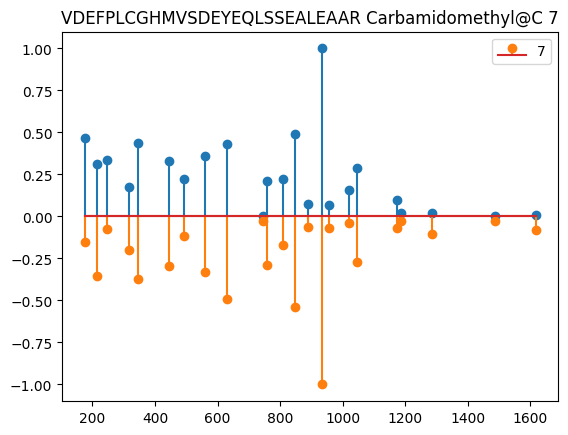

In [8]:
n = 11
print(precursor_df.loc[n, ['sequence', 'mods', 'mod_sites']])
isoform_attention_plot(spectral_library_flat, precursor_df, dia_data, precursor_df['mod_seq_charge_hash'].loc[n])

CAM + OX

sequence         IDPTVTMMQVEEKPDVTYSDVGGCK
mods         Oxidation@M;Carbamidomethyl@C
mod_sites                             8;24
Name: 5, dtype: object


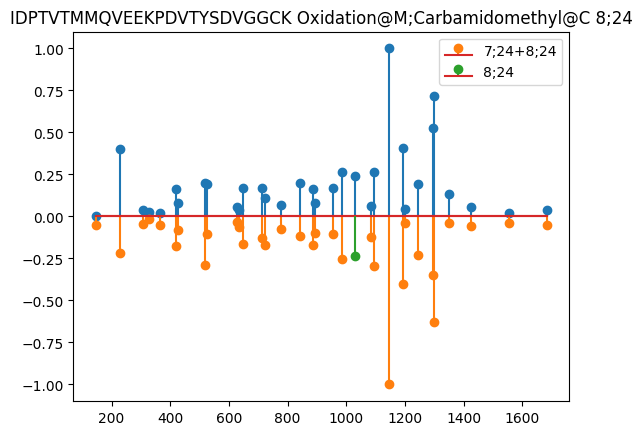

In [9]:
n = 5
print(precursor_df.loc[n, ['sequence', 'mods', 'mod_sites']])
isoform_attention_plot(spectral_library_flat, precursor_df, dia_data, precursor_df['mod_seq_charge_hash'].loc[n])

Multiple OX

sequence     AAFSEDGALMDGGMDLNMEQGMAEHLK
mods                         Oxidation@M
mod_sites                             14
Name: 45127, dtype: object


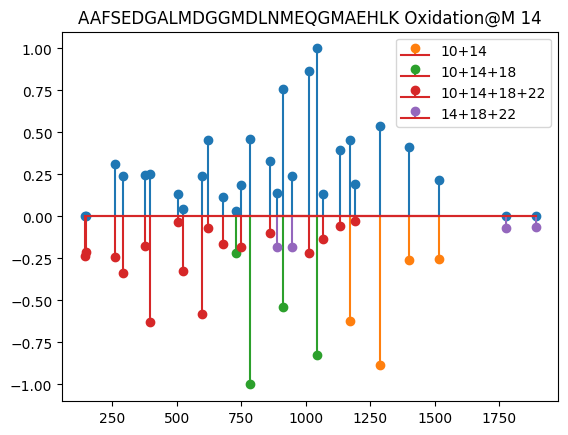

In [10]:
n = 45127
print(precursor_df.loc[n, ['sequence', 'mods', 'mod_sites']])
isoform_attention_plot(spectral_library_flat, precursor_df, dia_data, precursor_df['mod_seq_charge_hash'].loc[n])

No mods

sequence     GFFDPNTHENLTYLQLLQR
mods                            
mod_sites                       
Name: 451, dtype: object


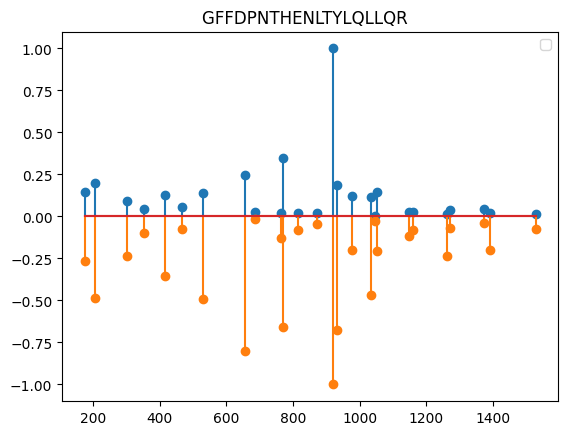

In [11]:
n = 451
print(precursor_df.loc[n, ['sequence', 'mods', 'mod_sites']])
isoform_attention_plot(spectral_library_flat, precursor_df, dia_data, precursor_df['mod_seq_charge_hash'].loc[n])